In [1]:
import xarray as xr, matplotlib.pyplot as plt
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import seaborn as sns
import dask.diagnostics # dask allows you to check how long something is taking to load
import climtas # needed to count event statistics with a specified duration

In [2]:
# import custom functions
import sys 
sys.path.append('/home/563/kb6999/Functions') # use this if the function file is in a different directory to the notebook

import frequently_used_functions as func
import plotting_functions as fplot
import model_functions as funcM
import reanalysis_functions as funcR

## Read in data

In [3]:
path = '/g/data/w48/kb6999/20CR_data_for_plots/'

In [173]:
# open lat lon mean of temperature 
llm_Glob = xr.open_dataset(f'{path}llm_mon_Glob.nc')
llm_NH = xr.open_dataset(f'{path}llm_mon_NH.nc')
llm_SH = xr.open_dataset(f'{path}llm_mon_SH.nc')
llm_Aus = xr.open_dataset(f'{path}llm_mon_Aus.nc')
llm_EA = xr.open_dataset(f'{path}llm_mon_EA.nc')

In [206]:
mon=6
llm_Glob = llm_Glob.rolling(time=mon).mean()
llm_NH = llm_NH.rolling(time=mon).mean()
llm_SH = llm_SH.rolling(time=mon).mean()
llm_Aus = llm_Aus.rolling(time=mon).mean()
llm_EA = llm_EA.rolling(time=mon).mean()

## Select our eruption dates

In [207]:
# eruption date
e_date = pd.to_datetime(['1883-08','1902-10', '1963-03', '1982-04', '1991-06'])

# save arrays of times relative to each eruption
e_pre5yrs = e_date - 60 * pd.offsets.MonthBegin()
e_pre3mon = e_date - 3 * pd.offsets.MonthBegin()
e_post5yrs = e_date + 61 * pd.offsets.MonthBegin()

In [208]:
# eruption names
volcanoes = ['Krakatoa', 'Santa Maria','Agung','El Chichon', 'Pinatubo']

In [209]:
# select out the 10 year time frame around each eruption (5yrs before and after)
Krakatoa_Glob = llm_Glob.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
SantaMaria_Glob = llm_Glob.sel(time = slice(e_pre5yrs[1], e_post5yrs[1]))
Agung_Glob = llm_Glob.sel(time = slice(e_pre5yrs[2], e_post5yrs[2]))
ElChicon_Glob = llm_Glob.sel(time = slice(e_pre5yrs[3], e_post5yrs[3]))
Pinatubo_Glob = llm_Glob.sel(time = slice(e_pre5yrs[4], e_post5yrs[4]))

In [210]:
# select out the 10 year time frame around each eruption (5yrs before and after)
Krakatoa_SH = llm_SH.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
SantaMaria_SH = llm_SH.sel(time = slice(e_pre5yrs[1], e_post5yrs[1]))
Agung_SH = llm_SH.sel(time = slice(e_pre5yrs[2], e_post5yrs[2]))
ElChicon_SH = llm_SH.sel(time = slice(e_pre5yrs[3], e_post5yrs[3]))
Pinatubo_SH = llm_SH.sel(time = slice(e_pre5yrs[4], e_post5yrs[4]))

In [211]:
# select out the 10 year time frame around each eruption (5yrs before and after)
Krakatoa_Aus = llm_Aus.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
SantaMaria_Aus = llm_Aus.sel(time = slice(e_pre5yrs[1], e_post5yrs[1]))
Agung_Aus = llm_Aus.sel(time = slice(e_pre5yrs[2], e_post5yrs[2]))
ElChicon_Aus = llm_Aus.sel(time = slice(e_pre5yrs[3], e_post5yrs[3]))
Pinatubo_Aus = llm_Aus.sel(time = slice(e_pre5yrs[4], e_post5yrs[4]))

In [212]:
# select out the 10 year time frame around each eruption (5yrs before and after)
Krakatoa_EA = llm_EA.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
SantaMaria_EA = llm_EA.sel(time = slice(e_pre5yrs[1], e_post5yrs[1]))
Agung_EA = llm_EA.sel(time = slice(e_pre5yrs[2], e_post5yrs[2]))
ElChicon_EA = llm_EA.sel(time = slice(e_pre5yrs[3], e_post5yrs[3]))
Pinatubo_EA = llm_EA.sel(time = slice(e_pre5yrs[4], e_post5yrs[4]))

## Anomalies

In [213]:
# store all eruptions in one array
composite_mon_Glob = funcM.reset_time(Krakatoa_Glob, SantaMaria_Glob, Agung_Glob, ElChicon_Glob, Pinatubo_Glob, volcanoes)

In [214]:
# select out each region
composite_mon_SH = funcM.reset_time(Krakatoa_SH, SantaMaria_SH, Agung_SH, ElChicon_SH, Pinatubo_SH, volcanoes)
composite_mon_Aus = funcM.reset_time(Krakatoa_Aus, SantaMaria_Aus, Agung_Aus, ElChicon_Aus, Pinatubo_Aus, volcanoes)
composite_mon_EA = funcM.reset_time(Krakatoa_EA, SantaMaria_EA, Agung_EA, ElChicon_EA, Pinatubo_EA, volcanoes)

## Multi-model mean and percentiles

In [215]:
# calculate the monthly model mean for monthly anomalies
composite_mmm_Glob = composite_mon_Glob.mean(dim='member')
composite_mmm_SH = composite_mon_SH.mean(dim='member')
composite_mmm_Aus = composite_mon_Aus.mean(dim='member')
composite_mmm_EA = composite_mon_EA.mean(dim='member')

In [216]:
# calcuate the lat lon mean (llm) to use for calculating percentiles
composite_llm_Glob = composite_mon_Glob
composite_llm_SH = composite_mon_SH
composite_llm_Aus = composite_mon_Aus
composite_llm_EA = composite_mon_EA

In [217]:
p = composite_llm_Glob.chunk({'member': -1,'volcano': -1}).quantile(0, dim=['member', 'volcano'])
p1 = composite_llm_Glob.chunk({'member': -1,'volcano': -1}).quantile(1, dim=['member', 'volcano'])

In [218]:
# calculate percentile
# 10th percentile
p10_Glob = composite_llm_Glob.chunk({'member': -1,'volcano': -1}).quantile(0.1, dim=['member', 'volcano'])
p10_SH = composite_llm_SH.chunk({'member': -1,'volcano': -1}).quantile(0.1, dim=['member', 'volcano'])
p10_Aus = composite_llm_Aus.chunk({'member': -1,'volcano': -1}).quantile(0.1, dim=['member', 'volcano'])
p10_EA = composite_llm_EA.chunk({'member': -1,'volcano': -1}).quantile(0.1, dim=['member', 'volcano'])

# 90th percentile
p90_Glob = composite_llm_Glob.chunk({'member': -1,'volcano': -1}).quantile(0.9, dim=['member', 'volcano'])
p90_SH = composite_llm_SH.chunk({'member': -1,'volcano': -1}).quantile(0.9, dim=['member', 'volcano'])
p90_Aus = composite_llm_Aus.chunk({'member': -1,'volcano': -1}).quantile(0.9, dim=['member', 'volcano'])
p90_EA = composite_llm_EA.chunk({'member': -1,'volcano': -1}).quantile(0.9, dim=['member', 'volcano'])

In [219]:
# take the composite over all volcanoes
V_composite_mmm_Glob = composite_mmm_Glob.mean(dim='volcano')
V_composite_mmm_SH = composite_mmm_SH.mean(dim='volcano')
V_composite_mmm_Aus = composite_mmm_Aus.mean(dim='volcano')
V_composite_mmm_EA = composite_mmm_EA.mean(dim='volcano')

# Minimum values

In [189]:
# calculate the minimum value of the mmm for each spatial region
composite_min_mmm_Glob = V_composite_mmm_Glob.min()
composite_min_mmm_SH = V_composite_mmm_SH.min()
composite_min_mmm_Aus = V_composite_mmm_Aus.min()
composite_min_mmm_EA = V_composite_mmm_EA.min()

In [24]:
# print minimum values for composite as calculated above
print('Minimum value of composite temperature signal on each spatial scale is:\n Global:', 
      composite_min_mmm_Glob.tmp.values.round(decimals=2), '\n SH:', 
      composite_min_mmm_SH.tmp.values.round(decimals=2), '\n Aus:', 
      composite_min_mmm_Aus.tmp.values.round(decimals=2), '\n EA:', 
      composite_min_mmm_EA.tmp.values.round(decimals=2))
print('Minimum value of composite precipitation signal on each spatial scale is:\n Global:', 
      composite_min_mmm_Glob.pr.values.round(decimals=2), '\n SH:', 
      composite_min_mmm_SH.pr.values.round(decimals=2), '\n Aus:', 
      composite_min_mmm_Aus.pr.values.round(decimals=2), '\n EA:', 
      composite_min_mmm_EA.pr.values.round(decimals=2))

KeyboardInterrupt: 

In [132]:
# calculate the minimum value for Krakatoa in each spatial region
K_min_mmm_Glob = composite_mmm_Glob.sel(volcano='Krakatoa').min()
K_min_mmm_SH = composite_mmm_SH.sel(volcano='Krakatoa').min()
K_min_mmm_Aus = composite_mmm_Aus.sel(volcano='Krakatoa').min()
K_min_mmm_EA = composite_mmm_EA.sel(volcano='Krakatoa').min()

In [ ]:
# print minimum values for Krakatoa as calculated above
print('Minimum value of composite temperature signal on each spatial scale is:\n Global:', 
      K_min_mmm_Glob.tmp.values.round(decimals=2), '\n SH:', K_min_mmm_SH.tmp.values.round(decimals=2), 
      '\n Aus:', K_min_mmm_Aus.tmp.values.round(decimals=2), '\n EA:', K_min_mmm_EA.tmp.values.round(decimals=2))
print('Minimum value of composite precipitation signal on each spatial scale is:\n Global:', 
      K_min_mmm_Glob.pr.values.round(decimals=2), '\n SH:', K_min_mmm_SH.pr.values.round(decimals=2), '\n Aus:', 
      K_min_mmm_Aus.pr.values.round(decimals=2), '\n EA:', K_min_mmm_EA.pr.values.round(decimals=2))

## Rolling mean

In [204]:
mon=6
# composite_mmm_Glob = composite_mmm_Glob.rolling(time=mon).mean()
# composite_mmm_SH = composite_mmm_SH.rolling(time=mon).mean()
# composite_mmm_Aus = composite_mmm_Aus.rolling(time=mon).mean()
# composite_mmm_EA = composite_mmm_EA.rolling(time=mon).mean()

V_composite_mmm_Glob = V_composite_mmm_Glob.rolling(time=mon).mean()
V_composite_mmm_SH = V_composite_mmm_SH.rolling(time=mon).mean()
V_composite_mmm_Aus = V_composite_mmm_Aus.rolling(time=mon).mean()
V_composite_mmm_EA = V_composite_mmm_EA.rolling(time=mon).mean()

## Figures

In [191]:
blues = sns.color_palette("Blues_r")
greens = sns.color_palette("Greens_r")
reds = sns.color_palette("Reds_r")

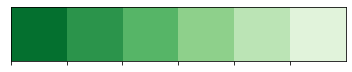

In [192]:
sns.palplot(sns.color_palette("Greens_r"))

In [193]:
# define degree sign
deg = u'\N{DEGREE SIGN}'

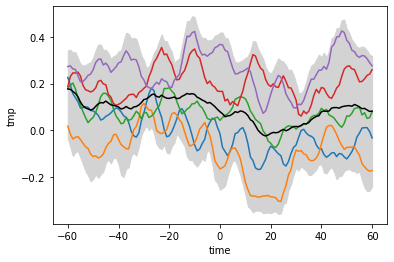

In [88]:
fig, ax = plt.subplots(1)
i=0
for v in composite_mmm_Glob.tmp.volcano:
    composite_mmm_Glob.tmp.sel(volcano=v).plot(ax=ax, label = v.data) # plot the anomalies 
    i = i+1

V_composite_mmm_Glob.tmp.plot(ax=ax, color='k')
ax.fill_between(p10_Glob.tmp.time, p.tmp, p1.tmp, color='lightgrey')

Below plot has the unchanged data for volcanoes and percentiles, BUT mmm is a 6-month rolling mean.  

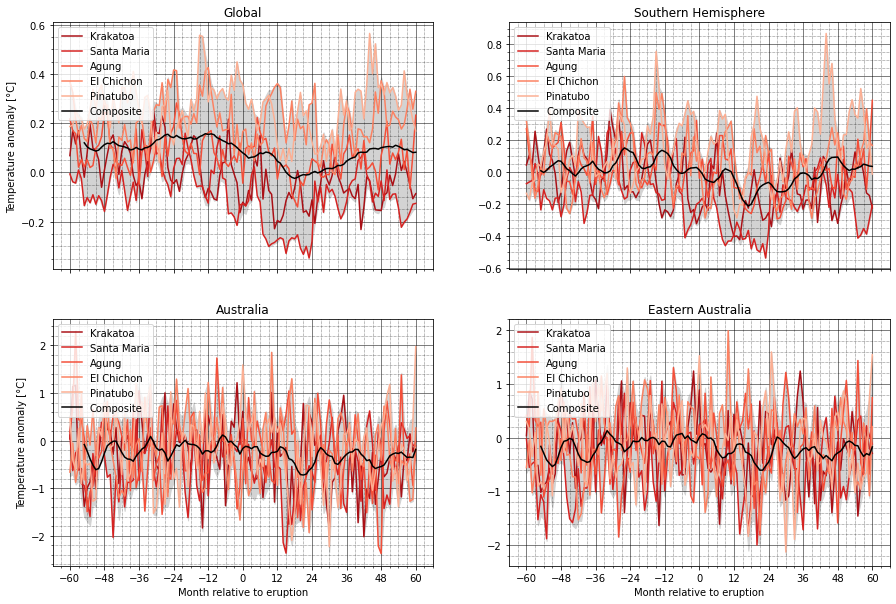

In [205]:
# plot monthly anomalies of temperature as a superposed epoch analysis of all 5 eruptions plus composite
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(15,10))

# make subplots for each region
fplot.SEA_plots(composite_mmm_Glob.tmp, V_composite_mmm_Glob.tmp, p10_Glob.tmp, p90_Glob.tmp, reds, ax = axes[0,0])
fplot.SEA_plots(composite_mmm_SH.tmp, V_composite_mmm_SH.tmp, p10_SH.tmp, p90_SH.tmp, reds, ax = axes[0,1])
fplot.SEA_plots(composite_mmm_Aus.tmp, V_composite_mmm_Aus.tmp, p10_Aus.tmp, p90_Aus.tmp, reds, ax = axes[1,0])
fplot.SEA_plots(composite_mmm_EA.tmp, V_composite_mmm_EA.tmp, p10_EA.tmp, p90_EA.tmp, reds, ax = axes[1,1])

# set axis labels and subplot titles
axes[0,0].set(ylabel = f'Temperature anomaly [{deg}C]', title = 'Global') 
axes[0,1].set(title = 'Southern Hemisphere')
axes[1,0].set(xlabel = 'Month relative to eruption', ylabel = f'Temperature anomaly [{deg}C]', title = 'Australia')
axes[1,1].set(xlabel = 'Month relative to eruption', title = 'Eastern Australia')

#fig.suptitle('Superposed epoch analysis of temperature anomalies for 5 major eruptions', size=16)

#fig.tight_layout() # if I include this line then titles overlap

plt.savefig('R_SEA_mon_tmp.png', dpi=300, bbox_inches='tight')

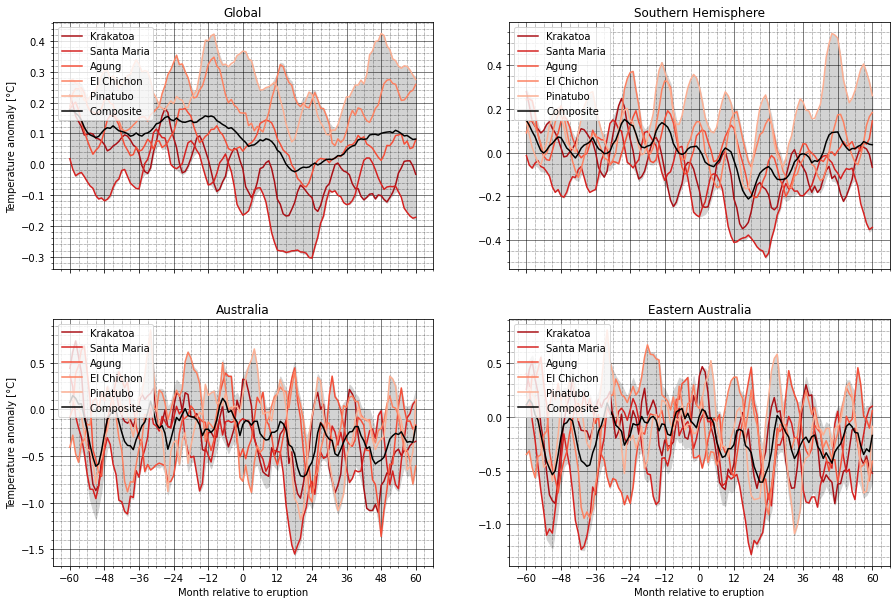

In [220]:
# plot monthly anomalies of temperature as a superposed epoch analysis of all 5 eruptions plus composite
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(15,10))

# make subplots for each region
fplot.SEA_plots(composite_mmm_Glob.tmp, V_composite_mmm_Glob.tmp, p10_Glob.tmp, p90_Glob.tmp, reds, ax = axes[0,0])
fplot.SEA_plots(composite_mmm_SH.tmp, V_composite_mmm_SH.tmp, p10_SH.tmp, p90_SH.tmp, reds, ax = axes[0,1])
fplot.SEA_plots(composite_mmm_Aus.tmp, V_composite_mmm_Aus.tmp, p10_Aus.tmp, p90_Aus.tmp, reds, ax = axes[1,0])
fplot.SEA_plots(composite_mmm_EA.tmp, V_composite_mmm_EA.tmp, p10_EA.tmp, p90_EA.tmp, reds, ax = axes[1,1])

# set axis labels and subplot titles
axes[0,0].set(ylabel = f'Temperature anomaly [{deg}C]', title = 'Global') 
axes[0,1].set(title = 'Southern Hemisphere')
axes[1,0].set(xlabel = 'Month relative to eruption', ylabel = f'Temperature anomaly [{deg}C]', title = 'Australia')
axes[1,1].set(xlabel = 'Month relative to eruption', title = 'Eastern Australia')

#fig.suptitle('Superposed epoch analysis of temperature anomalies for 5 major eruptions', size=16)

#fig.tight_layout() # if I include this line then titles overlap

plt.savefig('R_SEA_mon_tmp_roll6.png', dpi=300, bbox_inches='tight')